# Comparison of different Neural Network implementations

We implement the Multilayer Perceptron for regression. We compare our model with the implementation found in the sklearn Machine Learning library. 

## Regression

A regression problem consists of the process of learning a real-valued prediction function $f$ from data $(x_1,y_1)$, $(x_2,y_2)$,...,$(x_n,y_n)$. The goal is that after we learn the function $f$, when given a new unseen data point $x$, the output $f(x)$ will be close to the 'true' value of $y$.

## A description of the Multilayer Perceptron Algorithm

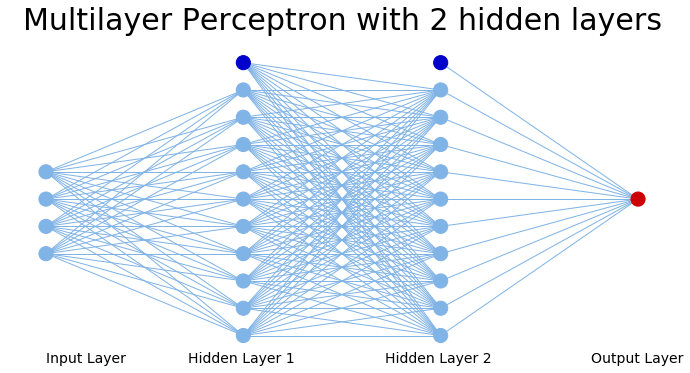

In [3]:
# Draws the Neural Network architecture for illustration purposes
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
ed = [[i,j,-1] for i in [0,1,2,3] for j in [4,5,6,7,8,9,10,11,12,13]]
ed = ed + [[i,j,-1] for i in [4,5,6,7,8,9,10,11,12,13] for j in [14,15,16,17,18,19,20,21,22,23]]
ed = ed + [[i,24,-1] for i in [14,15,16,17,18,19,20,21,22,23]]
ed=ed+[[25, j,-1] for j in [14,15,16,17,18,19,20,21,22,23]]+[[26,24,-1]]
pos={i:[0, 0.05*(i+1)+0.35] for i in [0,1,2,3]}
pos.update({i: [0.25, 0.05*(i+1)] for i in  [4,5,6,7,8,9,10,11,12,13] })
pos.update({i: [0.5, 0.05*(i-10+1)] for i in  [14,15,16,17,18,19,20,21,22,23] })
pos.update({24:[0.75,0.5], 25:[0.25, 0.05*(14+1)], 26:[0.5,0.05*(24-10+1)] })
color_map=[(0.5,0.7,0.9)]*24+[(0.8,0,0),(0,0,0.8),(0,0,0.8)]
G.add_weighted_edges_from(ed)
plt.figure(figsize=(12,6))
plt.title('Multilayer Perceptron with 2 hidden layers', fontsize=30)
plt.text(0, 0.2, 'Input Layer', fontsize=14)
plt.text(0.18, 0.2, 'Hidden Layer 1', fontsize=14)
plt.text(0.43, 0.2, 'Hidden Layer 2', fontsize=14)
plt.text(0.69, 0.2, 'Output Layer', fontsize=14)
nx.draw(G, with_labels=False, pos=pos, node_color=color_map, edge_color=(0.5,0.7,0.9), node_size=200)

In this notebook, we study a neural network approach to solve certain regression problems. The structure in the picture above is an example of a neural network called a multilayer perceptron. The algorithm  of the function NN_regressor below uses the data to learn $f$. We explain some of the steps now.
***
All the edges between the neuron represent weights which we will learn using the algorithm. We denote by $W_1, W_2, W_3$ the matrices of those weights. In the example depicted, those matrices have sizes $(10,4)$, $(10,11)$, $(1,11)$ respectively. Let $x=[x_1,x_2,...,x_d]$ represent a single data point where $d$ is the number of features. The nodes on the left represent the features of the data so the input layer has $d$ nodes. In every node of the 1st hidden layer, a function of the inputs $x_i$ is computed. The $j$-th neuron value is computed via $z^{(1)}_j=\sigma\big(\sum w^{(1)}_{ij}x_i\big)$ where $\sigma$ is a non-linear function called activation function. Here we use the ReLU function $\sigma(t)=\max(t,0)$. Before going to the 2nd hidden layer, we use a bias node, depicted by a blue node in the picture above which always has value $z^{(1)}_0=1$. Again we compute the $j$-th neuron via $z^{(2)}_j=\sigma\big(\sum w^{(2)}_{ij} z^{(1)}_i\big)$. Finally, after another bias node $z^{(2)}_0=1$, we calculate the value of the red node via $z^{(3)}=\sum w^{(3)}_{ij} z^{(2)}_i$. We just described the process of, given input $x$, producing output $y=z^{(3)}$ which is called a __forward pass__. Now we show how to find the suitable weights $W$ which will generalize to new data. The idea is to use the data and the forward pass to find a value for $\tilde{y}$, compare this with the true value $y$ and then adjust the weights in order to make the error $y-\tilde{y}$ as small as possible. For this the algorithm uses the backwards pass also known as __backpropagation__: We update the weights backwards via the rule $W \leftarrow W-\gamma \Delta W$ where $\Delta W$ is the gradient of $W$ and $\gamma$ is a user-defined parameter called the learning rate. The precise formula for $\Delta W$ is obtained using Calculus and it's implemented in the function back below.

In [ ]:
def NN_regressor(X, y, hidden_layers=[10, 10], rate=1e-6, iter_steps=5000):
    """Implement the Multilayer Perceptron. We use exactly two hidden layers and we don't use regularization. 
    Before returning the predictor, print evaluation scores."""
    
    #Importing data preparation modules
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler

    np.random.seed(0)
    
    # Data preparation
    scaler = MinMaxScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train=np.atleast_1d(y_train)
    y_test=np.atleast_1d(y_test)

    # Number of data points for training
    n=X_train.shape[0]
    # Input layer size
    h0=X_train.shape[1]
    # Hidden layers sizes without bias
    h1=hidden_layers[0]
    h2=hidden_layers[1]

    # The ReLU function and its derivative
    def relu(x):
        return np.maximum(x,0)
    def relu_derivative(x):
        x[x<=0]=0
        x[x>0]=1
        return x
    
    # The forward pass
    def forw(X, W_1, W_2, W_3):
        """The forward pass. Given a matrix of data and frozen weights, it computes the predicted output."""
        #W_1 has size (# of neurons in 1st hidden layer)x(#features)
        #W_2 has size (# of neurons in 2nd hidden layer)x(# of neurons in 1st hidden layer+1)
        #W_3 has size 1x(# of neurons in 2nd hidden layer+1)
        a_1=np.dot(W_1, X.T)
        z_1=relu(a_1)
        z_1=np.insert(z_1, 0, 1, axis=0) #prepend 1 for bias, has size (# of neurons in 1st hidden layer+1)x(#data)
        a_2=np.dot(W_2, z_1)
        z_2=relu(a_2)
        z_2=np.insert(z_2, 0, 1, axis=0) #prepend 1 for bias, has size (# of neurons in 2nd hidden layer+1)x(#data)
        z_3=np.dot(W_3, z_2) #has size 1x(#data)
        return (a_1, z_1, a_2, z_2, z_3)

    # The backward pass
    def back(a_1, z_1, a_2, z_2, z_3):
        """Backpropagation. Output the gradients of the weight matrices."""
        delta_3 = -2.0*(y_train.T-z_3)
        DW_3 = np.dot(delta_3, z_2.T)
        delta_2 =1.0*np.multiply(np.dot(W_3[:,1:].T, delta_3), relu_derivative(a_2))/n 
        DW_2 = np.dot(delta_2, z_1.T)
        delta_1 = 1.0*np.multiply(np.dot(W_2[:,1:].T, delta_2), relu_derivative(a_1))/n
        DW_1 = np.dot(delta_1, X_train_scaled) 
        return (DW_1, DW_2, DW_3)

    # Initialization of the weigths and biases
    W_1=np.random.normal(0, 1, (h1, h0))
    V_2=np.random.normal(0, 1, (h2, h1))
    b_2=np.zeros((h2, 1))
    W_2=np.concatenate((b_2, V_2), axis=1)
    V_3=np.random.normal(0, 1, (1, h2)) 
    b_3=np.zeros((1, 1))
    W_3=np.concatenate((b_3, V_3), axis=1)

    # Learning the weights from the training data points
    for _ in range(iter_steps):
        forward_weights = forw(X_train_scaled, W_1, W_2, W_3)
        backward_weights = back(*forward_weights)
        W_1=W_1-rate*backward_weights[0]
        W_2=W_2-rate*backward_weights[1]
        W_3=W_3-rate*backward_weights[2]

    # Evaluation
    y_train_pred =np.squeeze(forward_weights[4].T)
    print('Mean Squared Error on train set: {:.3f}'.format(np.mean((y_train-y_train_pred)**2)))
    forward_weights = forw(X_test_scaled, W_1, W_2, W_3)
    y_test_pred =np.squeeze(forward_weights[4].T)
    print('Mean Squared Error on test set: {:.3f}'.format(np.mean((y_test-y_test_pred)**2)))
             
    S_res=np.sum((y_train-y_train_pred)**2)
    S_tot=np.sum((y_train-np.mean(y_train))**2)     
    print('Coefficient of determination on test set: {:.3f}'.format(1-(S_res/S_tot))) 
    S_res_te=np.sum((y_test-y_test_pred)**2)
    S_tot_te=np.sum((y_test-np.mean(y_test))**2)     
    print('Coefficient of determination on test set: {:.3f}'.format(1-(S_res_te/S_tot_te)))
    
    # Return the regressor function
    return lambda X: np.squeeze(forw(X, W_1, W_2, W_3)[4].T)       

## In sklearn

In [ ]:
def NN_regressor_from_sklearn(X, y, hidden_layers=[10, 10], alpha=1):
    """The Multilayer Perceptron Regressor from sklearn. Before training, we prepare the data in the same way as above.
    Before returning the model, print evaluation scores."""

    from sklearn.neural_network import MLPRegressor
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error, r2_score
    
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    nnreg = MLPRegressor(hidden_layer_sizes = hidden_layers, activation = 'relu', 
                          alpha = alpha, solver = 'lbfgs').fit(X_train_scaled, y_train)
    
    y_train_pred = nnreg.predict(X_train_scaled)
    y_test_pred = nnreg.predict(X_test_scaled)
    
    print('Mean squared error on train set: {:.3f}'.format(mean_squared_error(y_train, y_train_pred)))
    print('Mean squared error on test set: {:.3f}'.format(mean_squared_error(y_test, y_test_pred)))
    print('Coefficient of determination on train set: {:.3f}'.format(r2_score(y_train, y_train_pred)))
    print('Coefficient of determination on test set: {:.3f}'.format(r2_score(y_test, y_test_pred)))

    return nnreg

In [ ]:
def Linear_Regressor_from_sklearn(X, y):
    """Linear Regression from sklearn. Before training, we prepare the data in the same way as above.
    Before returning the model, print evaluation scores."""
    
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error, r2_score
    
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linreg = LinearRegression().fit(X_train_scaled, y_train)
    
    y_train_pred = linreg.predict(X_train_scaled)
    y_test_pred = linreg.predict(X_test_scaled)
    
    print('Mean squared error on train set: {:.3f}'.format(mean_squared_error(y_train, y_train_pred)))
    print('Mean squared error on test set: {:.3f}'.format(mean_squared_error(y_test, y_test_pred)))
    print('Coefficient of determination on train set: {:.3f}'.format(r2_score(y_train, y_train_pred)))
    print('Coefficient of determination on test set: {:.3f}'.format(r2_score(y_test, y_test_pred)))

    return linreg

## In Tensorflow

To be added

## Data sets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.datasets import load_diabetes, load_boston

data_diabetes=load_diabetes()
data_boston=load_boston()

##### Diabetes dataset
Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

In [ ]:
X_diabetes=pd.DataFrame(data_diabetes['data'], columns=data_diabetes['feature_names'])
y_diabetes=pd.Series(data_diabetes['target'])

In [ ]:
X_diabetes.head(2)

##### Boston dataset
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. ‘Hedonic prices and the demand for clean air’, J. Environ. Economics & Management, vol.5, 81-102, 1978.

In [ ]:
X_boston=pd.DataFrame(data_boston['data'], columns=data_boston['feature_names'])
y_boston=pd.Series(data_boston['target'])

In [ ]:
X_boston.head(2)

## Testing

In [ ]:
print('Evaluation of our Multilayer Perceptron trained on the diabetes dataset\n')
nnreg_diabetes=NN_regressor(X_diabetes, y_diabetes, hidden_layers=[20, 20], rate=1e-7, iter_steps=10000)

In [ ]:
print('Evaluation of the Multilayer Perceptron in sklearn\n')
nnreg_from_sklearn_diabetes=NN_regressor_from_sklearn(X_diabetes, y_diabetes, hidden_layers=[20, 20], alpha=5000)

In [ ]:
print('Linear Regression for comparison\n')
linreg_from_sklearn_diabetes=Linear_Regressor_from_sklearn(X_diabetes, y_diabetes)

***

In [ ]:
print('Evaluation of our Multilayer Perceptron trained on the Boston housing dataset\n')
nnreg_boston=NN_regressor(X_boston, y_boston, hidden_layers=[20, 20], rate=1e-4, iter_steps=10000)

In [ ]:
print('Evaluation of the Multilayer Perceptron in sklearn\n')
nnreg_from_sklearn_boston=NN_regressor_from_sklearn(X_boston, y_boston, hidden_layers=[10, 10], alpha=200)

In [ ]:
print('Linear Regression for comparison\n')
linreg_from_sklearn_boston=Linear_Regressor_from_sklearn(X_boston, y_boston)

##### End of notebook